## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run the data preparation notebook
X_lstm = np.load("npy_files/X_lstm.npy")
anomaly_list = np.load("npy_files/anomaly_list.npy") #0 for normal. 1 for anomaly


In [2]:
X_lstm.shape

(6711, 7, 9)

In [3]:
pd.DataFrame(X_lstm[0,:,:])

,0,1,2,3,4,5,6,7,8
0,8.368,5.5425,0.0,8.0,6.0,0.0,0.0,8.0,8.0
1,9.692,6.1375,1.0,9.0,5.0,1.0,0.0,10.0,10.0
2,9.780,3.6950,25.0,0.0,25.0,25.0,0.0,25.0,25.0
3,9.364,3.7175,25.0,0.0,25.0,25.0,0.0,25.0,25.0
4,8.960,0.0425,26.0,0.0,26.0,26.0,0.0,26.0,26.0
5,8.588,0.0425,25.0,0.0,25.0,25.0,0.0,25.0,25.0
6,8.244,0.0425,24.0,2.0,26.0,24.0,0.0,26.0,26.0


#### Divide into train data and test data

In [4]:
# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_lstm

normal_train_data = np.empty((0, 7, 9))  # Empty array with correct shape
anomalous_train_data = np.empty((0, 7, 9))
normal_val_data = np.empty((0, 7, 9))
anomalous_val_data = np.empty((0, 7, 9))
normal_test_data = np.empty((0, 7, 9))
anomalous_test_data = np.empty((0, 7, 9))


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
split_index = 1262 #June 1st index
split_index2 = 2865 #July 1st index

# Split the data and labels
train_data = data[:split_index]
val_data = data[split_index:split_index2]
test_data = data[split_index2:]

train_labels = labels[:split_index]
val_labels = labels[split_index:split_index2]
test_labels = labels[split_index2:]

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Pass to float
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data = train_data.numpy()
val_data = val_data.numpy()
test_data = test_data.numpy()

#Separate into normal and anomalous data
for i in range(len(train_labels)):
     if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :, :]), axis=0)
     else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :, :]), axis=0)

for i in range(len(val_labels)):
       if val_labels[i] == 0:
         normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :, :]), axis=0)
       else:
         anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :, :]), axis=0)

for i in range(len(test_labels)):
     if test_labels[i] == 0:
        normal_test_data = np.concatenate((normal_test_data, test_data[i:i+1, :, :]), axis=0)
     else:
        anomalous_test_data = np.concatenate((anomalous_test_data, test_data[i:i+1, :, :]), axis=0)


#### Deciding the different sets' sizes and positions

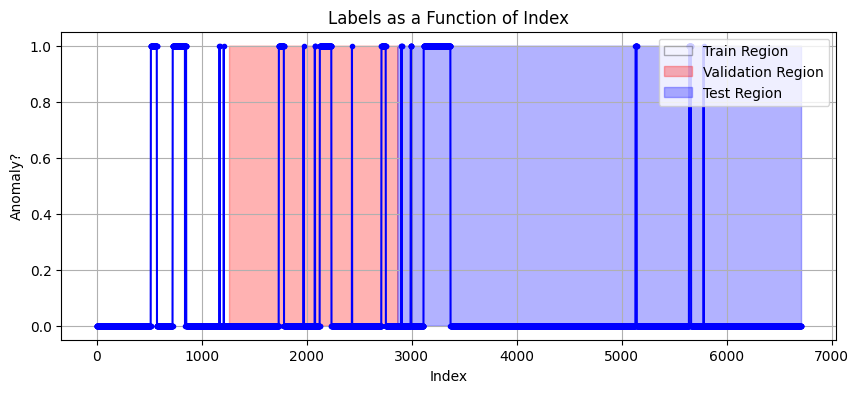

In [5]:
from matplotlib.patches import Patch
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, 'b.-', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index) & (np.arange(len(labels)) < split_index2), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index2), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='white', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels as a Function of Index')
plt.grid(True)
plt.show()

In [6]:
sum(anomaly_list)/len(anomaly_list)

np.float64(0.1034123081507972)

In [7]:
from collections import Counter
def calculate_proportions(labels):
    counter = Counter(labels)
    total = len(labels)
    true_proportion = counter[True] / total
    false_proportion = counter[False] / total
    return true_proportion, false_proportion

# Calculate proportions for each list
train_true_prop, train_false_prop = calculate_proportions(train_labels)
val_true_prop, val_false_prop = calculate_proportions(val_labels)
test_true_prop, test_false_prop = calculate_proportions(test_labels)
# Print the proportions
print(f"Train Labels ({len(train_labels)} samples) -     Normal: {train_false_prop*100:.2f}%, Anomalous: {train_true_prop*100:.2f}%")
print(f"Validation Labels ({len(val_labels)} samples) - Normal: {val_false_prop*100:.2f}%, Anomalous: {val_true_prop*100:.2f}%")
print(f"Test Labels ({len(test_labels)} samples) -       Normal: {test_false_prop*100:.2f}%, Anomalous: {test_true_prop*100:.2f}%")


Train Labels (1262 samples) -     Normal: 85.02%, Anomalous: 14.98%
Validation Labels (1603 samples) - Normal: 87.09%, Anomalous: 12.91%
Test Labels (3846 samples) -       Normal: 92.25%, Anomalous: 7.75%


In [8]:
normal_train_data.shape

(1073, 7, 9)

In [9]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

train_reshaped = train_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
train_scaled = scaler.fit_transform(train_reshaped)  # Fit and transform
train_data = train_scaled.reshape(train_data.shape)  # Reshape back

val_reshaped = val_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
val_scaled = scaler.transform(val_reshaped)  # Transform (using the scaler fitted on train data)
val_data = val_scaled.reshape(val_data.shape)  # Reshape back

test_reshaped = test_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
test_scaled = scaler.transform(test_reshaped)  # Transform (using the scaler fitted on train data)
test_data = test_scaled.reshape(test_data.shape)  # Reshape back

# Reshape the normal training data to 2D, fit the scaler, and transform it
normal_train_reshaped = normal_train_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
normal_train_scaled = scaler.fit_transform(normal_train_reshaped)  # Fit and transform
normal_train_data = normal_train_scaled.reshape(normal_train_data.shape)  # Reshape back

# Reshape and transform the rest of the datasets using the same scaler
# Normal validation data
normal_val_reshaped = normal_val_data.reshape(-1, 9)
normal_val_scaled = scaler.transform(normal_val_reshaped)
normal_val_data = normal_val_scaled.reshape(normal_val_data.shape)

# Normal test data
normal_test_reshaped = normal_test_data.reshape(-1, 9)
normal_test_scaled = scaler.transform(normal_test_reshaped)
normal_test_data = normal_test_scaled.reshape(normal_test_data.shape)

# Anomalous training data
anomalous_train_reshaped = anomalous_train_data.reshape(-1, 9)
anomalous_train_scaled = scaler.transform(anomalous_train_reshaped)
anomalous_train_data = anomalous_train_scaled.reshape(anomalous_train_data.shape)

# Anomalous validation data
anomalous_val_reshaped = anomalous_val_data.reshape(-1, 9)
anomalous_val_scaled = scaler.transform(anomalous_val_reshaped)
anomalous_val_data = anomalous_val_scaled.reshape(anomalous_val_data.shape)

# Anomalous test data
anomalous_test_reshaped = anomalous_test_data.reshape(-1, 9)
anomalous_test_scaled = scaler.transform(anomalous_test_reshaped)
anomalous_test_data = anomalous_test_scaled.reshape(anomalous_test_data.shape)

## Autoencoder

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 58.9375 - val_loss: 23.8378
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.2332 - val_loss: 15.4353
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.2524 - val_loss: 11.1675
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.4636 - val_loss: 8.4962
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0409 - val_loss: 6.6770
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3632 - val_loss: 5.3691
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1324 - val_loss: 4.3922
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2145 - val_loss: 3.6394
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4963 - val_loss: 3.0460
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9321 - val_loss: 2.5686
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4730 - val_loss: 2.1788
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12

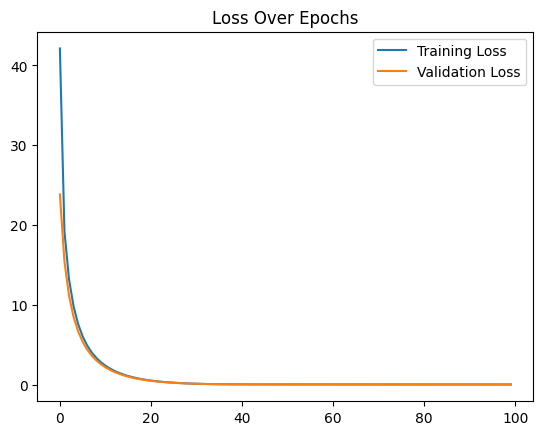

In [10]:
# Define input dimension
timesteps = normal_train_data.shape[1] #7 timesteps
features = normal_train_data.shape[2] #9 features

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data,  # Input and target are the same for autoencoders
    y=normal_train_data,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data, normal_val_data)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Threshold:  0.06860686
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


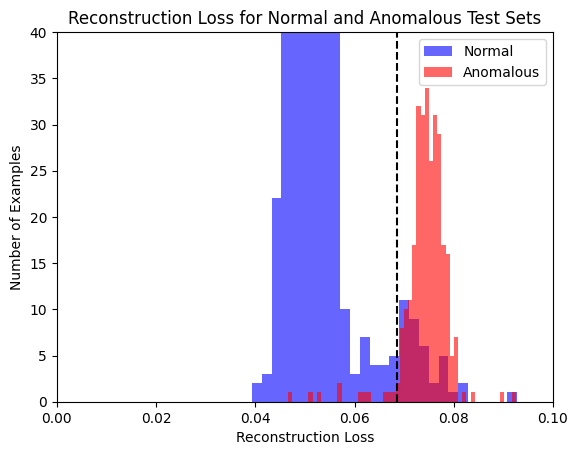

Accuracy = 98.4659386375455%
Precision = 85.67164179104478%
Recall = 96.30872483221476%
F1 Score = 90.67930489731437%


In [11]:
from sklearn.metrics import precision_recall_curve

# Suppose y_true are your binary labels (1 for anomaly, 0 for normal)
# and scores are the anomaly scores (or probabilities) from your model.
# For example:
reconstructions_normal = autoencoder.predict(val_data)
val_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, val_data), axis=1)

y_true = (np.array(val_labels) != 0).astype(int)
scores = np.array(val_loss)

# 1. Calculate precision, recall, and thresholds.
precision, recall, thresholds = precision_recall_curve(y_true, scores)

# Note: precision and recall arrays have one extra element compared to thresholds.
# We'll compute F1 scores for the thresholds only.
# F1 = 2 * (precision * recall) / (precision + recall)
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety

# 2. Identify the best threshold (maximizing F1 score)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]
best_f1 = f1_scores[best_idx]

print("Threshold: ", best_threshold)

# Calculate the reconstruction loss for the anomalous test data
reconstructions_test_normal = autoencoder.predict(normal_test_data)
normal_test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_test_normal, normal_test_data), axis=1)

reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data)
anomalous_test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data), axis=1)

# Plot both losses on the same histogram
plt.hist(normal_test_loss, bins=500, alpha=0.6, color='blue', label='Normal')
plt.hist(anomalous_test_loss, bins=100, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous Test Sets")
plt.axvline(x=best_threshold, color='black', linestyle='--')
plt.ylim((0, 40))
plt.xlim((0,.1))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

preds = predict(autoencoder, test_data, best_threshold)
print_stats(preds, test_labels)

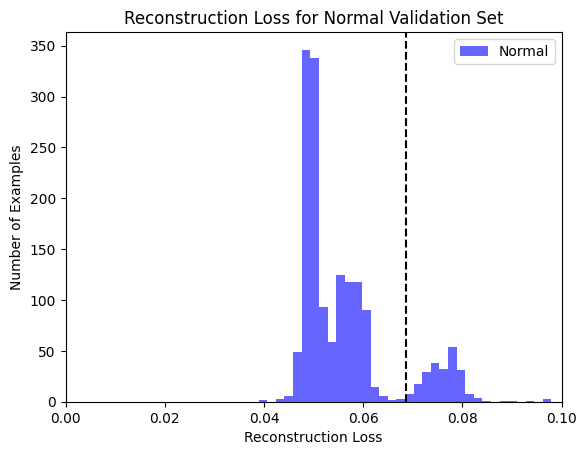

In [13]:
# Plot both losses on the same histogram
plt.hist(val_loss, bins=500, alpha=0.6, color='blue', label='Normal')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal Validation Set")
plt.axvline(x=best_threshold, color='black', linestyle='--')
#plt.ylim((0, 40))
plt.xlim((0,.1))
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 287   11]
 [  48 3500]]


Confusion Matrix (sklearn):\
\
$\begin{pmatrix}
\textrm{True anomaly} & \textrm{False positive: Anomaly falsely flagged as normal}\\
\textrm{False negative: Normal falsely flagged as anomaly} & \textrm{True normal}\\
\end{pmatrix}$

# _________________________________________________________________________________________________

# Feature Importance (by hand)

In [ ]:
# Function to calculate feature importance
def feature_importance_analysis(autoencoder, data, timesteps, features):
    # Baseline reconstruction error
    baseline_reconstruction = autoencoder.predict(data)
    baseline_error = np.mean(np.square(data - baseline_reconstruction), axis=(1, 2))

    # Initialize a matrix to store feature importance
    feature_importance = np.zeros((timesteps, features))

    # Iterate over each feature and time-step
    for t in range(timesteps):
        for f in range(features):
            # Perturb the feature at time-step t
            perturbed_data = data.copy()
            perturbed_data[:, t, f] = 0  # Set feature to zero (or add noise)

            # Reconstruct the perturbed data
            perturbed_reconstruction = autoencoder.predict(perturbed_data)
            perturbed_error = np.mean(np.square(data - perturbed_reconstruction), axis=(1, 2))

            # Calculate the increase in error due to perturbation
            feature_importance[t, f] = np.mean(perturbed_error - baseline_error)

    return feature_importance

# Run feature importance analysis
feature_importance = feature_importance_analysis(autoencoder, normal_train_data, timesteps, features)

# Print or visualize the results
print("Feature Importance (Time-step x Feature):")
print(feature_importance)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
78/78 ━━━━━━━━━━━━━━━━━━━

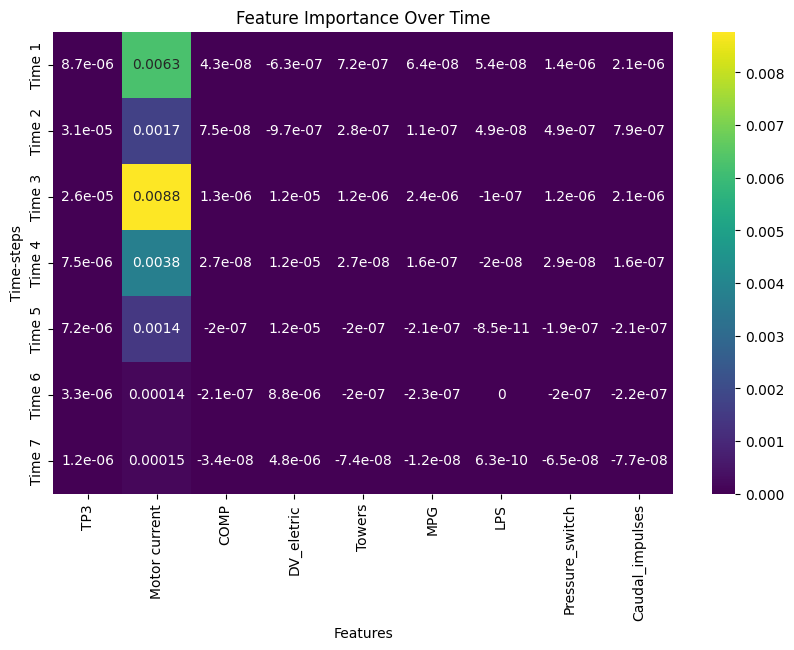

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for feature importance over time
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance, annot=True, cmap='viridis', 
            xticklabels=[f'{i}' for i in ['TP3','Motor current','COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Caudal_impulses']],
            yticklabels=[f'Time {i+1}' for i in range(timesteps)])
plt.title('Feature Importance Over Time')
plt.xlabel('Features')
plt.ylabel('Time-steps')
plt.show()

#### Averaging over time-steps

In [ ]:
#Averaging over time-steps
averaged_feature_importance = np.mean(feature_importance, axis=0)
print("Averaged Feature Importance:")
print(averaged_feature_importance)

Averaged Feature Importance:
[ 1.21259899e-05  3.17010077e-03  1.50914340e-07  7.01926833e-06
  2.54992886e-07  3.20106540e-07 -2.49144448e-09  3.90554140e-07
  6.70361441e-07]


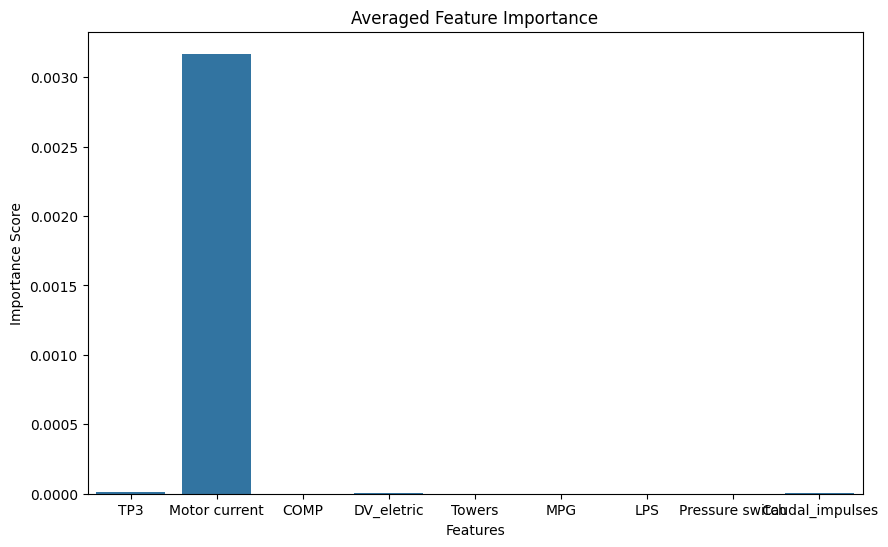

In [ ]:
# Bar plot for averaged feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=[f'{i}' for i in ['TP3','Motor current','COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure switch', 'Caudal_impulses']], y=averaged_feature_importance)
plt.title('Averaged Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

# Feature Importance (SHAP value analysis)

In [ ]:
normal_train_data.shape

(2469, 7, 9)

In [ ]:
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten function to reshape input data
def flatten_input(data):
    return data.reshape((data.shape[0], -1))  # Shape: (num_samples, 63)

# Wrapper function for autoencoder that computes reconstruction error
def reconstruction_error(flattened_data):
    # Reshape back to original shape: (num_samples, 7, 9)
    data = flattened_data.reshape((-1, 7, 9))
    reconstructed = autoencoder.predict(data)
    
    # Compute the mean squared error (MSE) for each sample
    error = np.mean(np.square(data - reconstructed), axis=(1, 2))  # Shape: (num_samples,)
    return error

# Step 1: Prepare the background data (reshape it)
background_data = flatten_input(normal_train_data[:100])  # Shape: (100, 63)

# Step 2: Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(reconstruction_error, background_data)

# Step 3: Prepare sample data (reshape it)
sample_data = flatten_input(normal_train_data[:200])  # Shape: (200, 63)

# Step 4: Calculate SHAP values
shap_values = explainer.shap_values(sample_data)  # Shape: (200,)

# Step 5: Reshape SHAP values back to (200, 7, 9) for visualization
shap_values = np.array(shap_values).reshape((200, 7, 9))

# Step 6: Summarize and visualize the SHAP values
shap.summary_plot(shap_values.reshape(-1, 9), 
                  feature_names=['TP3', 'Motor current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Caudal_impulses'])

# Step 7: Heatmap of SHAP values over time
averaged_shap_values = np.mean(shap_values, axis=0)  # Shape: (7, 9)

plt.figure(figsize=(10, 6))
sns.heatmap(averaged_shap_values, annot=True, cmap='viridis', 
            xticklabels=['TP3', 'Motor current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Caudal_impulses'],
            yticklabels=[f'Time {i+1}' for i in range(7)])
plt.title('Averaged SHAP Values Over Time')
plt.xlabel('Features')
plt.ylabel('Time-steps')
plt.show()

# Step 8: Bar plot for averaged SHAP values across all time-steps
averaged_shap_across_time = np.mean(averaged_shap_values, axis=0)  # Shape: (9,)

plt.figure(figsize=(10, 6))
sns.barplot(x=['TP3', 'Motor current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Caudal_impulses'], y=averaged_shap_across_time)
plt.title('Averaged SHAP Values Across All Time-steps')
plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.show()


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6705/6732 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

  0%|          | 0/200 [00:13<?, ?it/s]


KeyboardInterrupt: 

# Rebuilding Autoencoder w/ insights from Feature Importance Analysis

### Removing just TP3 or just Motor current

#### Test the results of the handmade algorithm (running without Motor current)

In [ ]:
# Remove the second column (index 1) from each dataset
train_data_no_mc = np.delete(train_data, 1, axis=2)
val_data_no_mc = np.delete(val_data, 1, axis=2)
test_data_no_mc = np.delete(test_data, 1, axis=2)

normal_train_data_no_mc = np.delete(normal_train_data, 1, axis=2)
normal_val_data_no_mc = np.delete(normal_val_data, 1, axis=2)
normal_test_data_no_mc = np.delete(normal_test_data, 1, axis=2)

anomalous_train_data_no_mc = np.delete(anomalous_train_data, 1, axis=2)
anomalous_val_data_no_mc = np.delete(anomalous_val_data, 1, axis=2)
anomalous_test_data_no_mc = np.delete(anomalous_test_data, 1, axis=2)

pd.DataFrame(normal_train_data_no_mc[0,:,:]).head(7)

,0,1,2,3,4,5,6,7
0,0.834169,0.000000,0.000675,0.000000,0.000000,0.0,0.000675,0.000675
1,0.938331,0.000000,0.000810,0.000675,0.000000,0.0,0.000810,0.000810
2,0.959250,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
3,0.913707,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
4,0.871868,0.013814,0.000000,0.003781,0.013814,0.0,0.003780,0.003780
5,0.830900,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
6,0.793637,0.013320,0.000135,0.003781,0.013320,0.0,0.003780,0.003780


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 49.4500 - val_loss: 17.2931
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.9049 - val_loss: 9.6789
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.5980 - val_loss: 6.0534
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4525 - val_loss: 3.9996
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6305 - val_loss: 2.7299
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4906 - val_loss: 1.9082
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7503 - val_loss: 1.3609
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2532 - val_loss: 0.9887
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9142 - val_loss: 0.7308
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6789 - val_loss: 0.5495
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5121 - val_loss: 0.4203
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

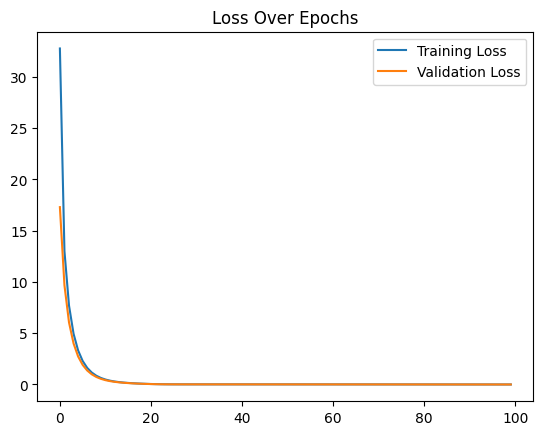

In [ ]:
# Define input dimension
timesteps = normal_train_data.shape[1] #7 timesteps
features = normal_train_data.shape[2]-1 #8 features

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_no_mc,  # Input and target are the same for autoencoders
    y=normal_train_data_no_mc,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data_no_mc, normal_val_data_no_mc)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Threshold:  0.02012946816547804
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


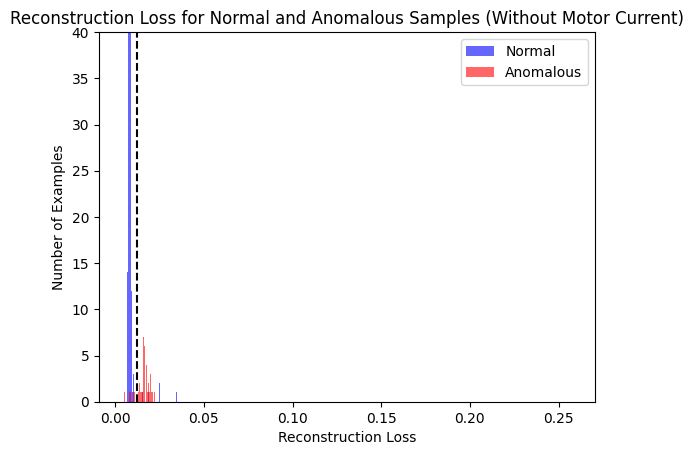

Accuracy = 94.62102689486552%
Precision = 95.55555555555556%
Recall = 98.28571428571429%
F1 Score = 96.90140845070422%
Confusion Matrix:
[[ 43  16]
 [  6 344]]


In [ ]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_val_data_no_mc)
train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_val_data_no_mc), axis=1)


threshold = np.mean(train_loss) + 1*np.std(train_loss)
print("Threshold: ", threshold)
threshold=0.0125 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data_no_mc)
test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data_no_mc), axis=1)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=1000, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous Samples (Without Motor Current)")
plt.axvline(x=threshold, color='black', linestyle='--')
plt.ylim((0, 40))
#plt.xlim((0,0.03))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data_no_mc, threshold)
print_stats(preds, test_labels)

# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

#### Test the results of the shap values algorithm (running without TP3)

In [ ]:
# Remove the second column (index 1) from each dataset
train_data_no_tp3 = np.delete(train_data, 0, axis=2)
val_data_no_tp3 = np.delete(val_data, 0, axis=2)
test_data_no_tp3 = np.delete(test_data, 0, axis=2)

normal_train_data_no_tp3 = np.delete(normal_train_data, 0, axis=2)
normal_val_data_no_tp3 = np.delete(normal_val_data, 0, axis=2)
normal_test_data_no_tp3 = np.delete(normal_test_data, 0, axis=2)

anomalous_train_data_no_tp3 = np.delete(anomalous_train_data, 0, axis=2)
anomalous_val_data_no_tp3 = np.delete(anomalous_val_data, 0, axis=2)
anomalous_test_data_no_tp3 = np.delete(anomalous_test_data, 0, axis=2)

pd.DataFrame(normal_train_data_no_tp3[0,:,:]).head(7)

,0,1,2,3,4,5,6,7
0,0.913423,0.000000,0.000675,0.000000,0.000000,0.0,0.000675,0.000675
1,0.925735,0.000000,0.000810,0.000675,0.000000,0.0,0.000810,0.000810
2,0.551628,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
3,0.567911,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
4,0.003177,0.013814,0.000000,0.003781,0.013814,0.0,0.003780,0.003780
5,0.003177,0.013320,0.000000,0.003646,0.013320,0.0,0.003645,0.003645
6,0.003177,0.013320,0.000135,0.003781,0.013320,0.0,0.003780,0.003780


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 50.4428 - val_loss: 18.3289
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.1265 - val_loss: 10.6550
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7499 - val_loss: 6.9402
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4895 - val_loss: 4.7820
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5274 - val_loss: 3.3983
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2475 - val_loss: 2.4638
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3744 - val_loss: 1.8150
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7582 - val_loss: 1.3577
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3275 - val_loss: 1.0313
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0084 - val_loss: 0.7949
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7823 - val_loss: 0.6213
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss

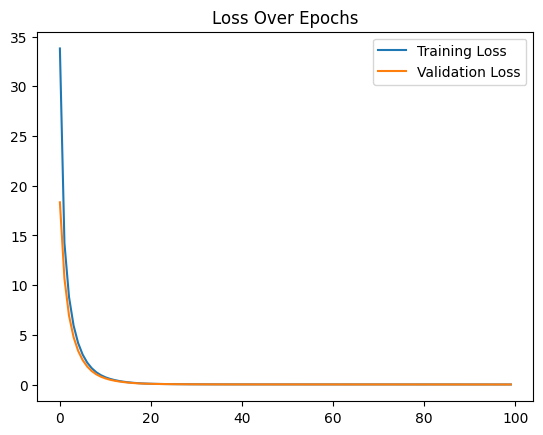

In [ ]:
# Define input dimension
timesteps = normal_train_data.shape[1] #7 timesteps
features = normal_train_data.shape[2]-1 #8 features

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_no_tp3,  # Input and target are the same for autoencoders
    y=normal_train_data_no_tp3,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data_no_tp3, normal_val_data_no_tp3)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Threshold:  0.05142867621268891
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


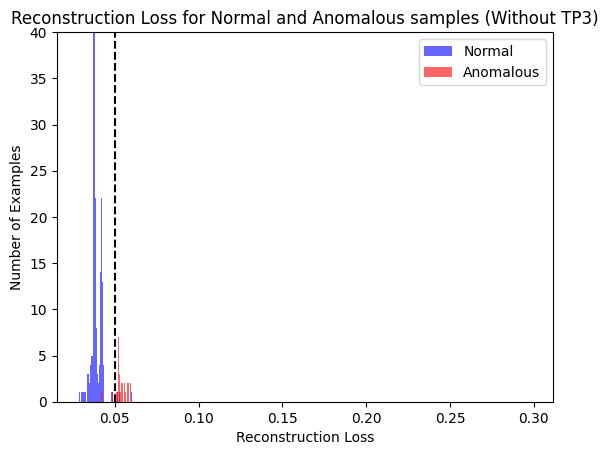

Accuracy = 97.06601466992664%
Precision = 97.74011299435028%
Recall = 98.85714285714286%
F1 Score = 98.29545454545455%
Confusion Matrix:
[[ 51   8]
 [  4 346]]


In [ ]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_val_data_no_tp3)
train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_val_data_no_tp3), axis=1)


threshold = np.mean(train_loss) + 1*np.std(train_loss)
print("Threshold: ", threshold)
threshold=0.05 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data_no_tp3)
test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data_no_tp3), axis=1)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=1000, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous samples (Without TP3)")
plt.axvline(x=threshold, color='black', linestyle='--')
plt.ylim((0, 40))
#plt.xlim((0,0.03))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data_no_tp3, threshold)
print_stats(preds, test_labels)

# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

These results lead us to think that the first method of feature importance analysis was probably in the right. We see that the reconstruction loss is greatly diminished when the motor current data is removed from the problem. When removing TP3, however, we see that the loss remains more or less the same.

However, our purpouse in this problem is not arriving at a low reconstruction loss, but rather being able to identify anomalies. When looking at this goal, and even though the reconstruction losses are not the same in different scenarios, we find that the metrics (Accuracy, Precision, Recall, F1 Score) -- as well as the confusion matrix -- show approximately the same results in all three cases (original data, without motor current, and without TP3).

For the sake of simplifying our problem, let us remove **all the columns for which our analysis returned a low score.**

### Removing all columns close to 0 score in our analysis

In [ ]:
# Remove the second column (index 1) from each dataset
train_data_important = np.delete(train_data, [3,4,7,8], axis=2)
val_data_important = np.delete(val_data, [3,4,7,8], axis=2)
test_data_important = np.delete(test_data, [3,4,7,8], axis=2)

normal_train_data_important = np.delete(normal_train_data, [3,4,7,8], axis=2)
normal_val_data_important = np.delete(normal_val_data, [3,4,7,8], axis=2)
normal_test_data_important = np.delete(normal_test_data, [3,4,7,8], axis=2)

anomalous_train_data_important = np.delete(anomalous_train_data, [3,4,7,8], axis=2)
anomalous_val_data_important = np.delete(anomalous_val_data, [3,4,7,8], axis=2)
anomalous_test_data_important = np.delete(anomalous_test_data, [3,4,7,8], axis=2)

pd.DataFrame(normal_train_data_important[0,:,:]).head(7)

,0,1,2,3,4
0,0.834169,0.913423,0.000000,0.000000,0.0
1,0.938331,0.925735,0.000000,0.000000,0.0
2,0.959250,0.551628,0.013320,0.013320,0.0
3,0.913707,0.567911,0.013320,0.013320,0.0
4,0.871868,0.003177,0.013814,0.013814,0.0
5,0.830900,0.003177,0.013320,0.013320,0.0
6,0.793637,0.003177,0.013320,0.013320,0.0


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 48.2800 - val_loss: 16.0817
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.9063 - val_loss: 8.8266
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9654 - val_loss: 5.5776
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1456 - val_loss: 3.7943
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5459 - val_loss: 2.6972
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5355 - val_loss: 1.9713
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8613 - val_loss: 1.4673
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3877 - val_loss: 1.1055
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0450 - val_loss: 0.8408
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7954 - val_loss: 0.6429
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6089 - val_loss: 0.4945
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss:

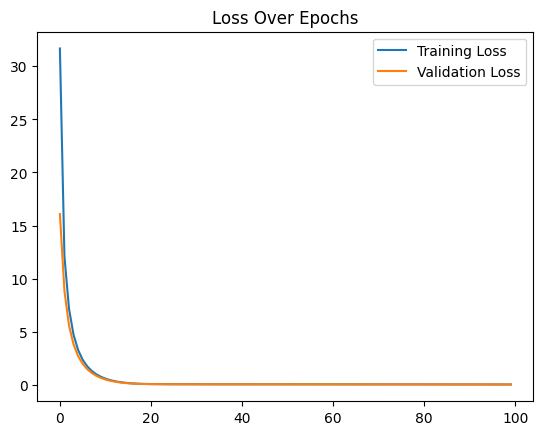

In [ ]:
# Define input dimension
timesteps = normal_train_data.shape[1] #7 timesteps
features = normal_train_data.shape[2]-4 #5 features

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_important,  # Input and target are the same for autoencoders
    y=normal_train_data_important,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data_important, normal_val_data_important)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Threshold:  0.08955887495458273
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


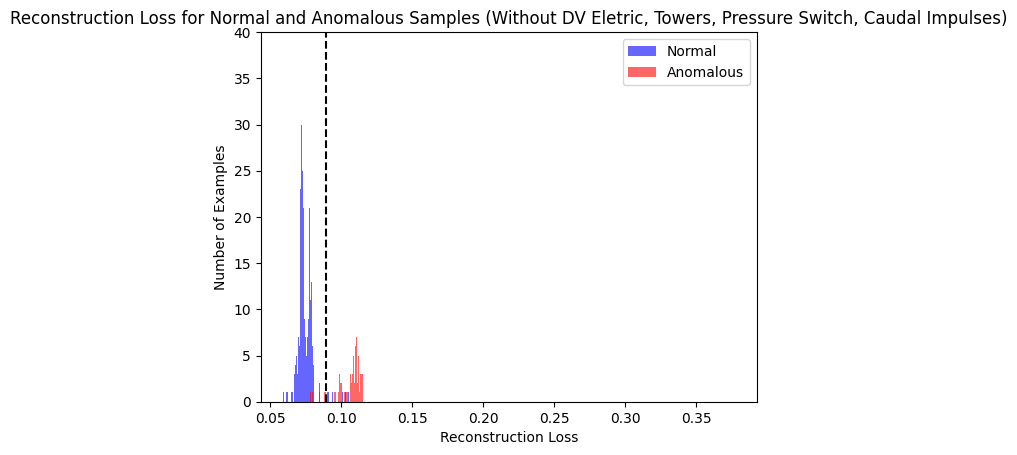

Accuracy = 97.31051344743277%
Precision = 98.56733524355302%
Recall = 98.28571428571429%
F1 Score = 98.42632331902719%
Confusion Matrix:
[[ 54   5]
 [  6 344]]


In [ ]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_val_data_important)
train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_val_data_important), axis=1)


threshold = np.mean(train_loss) + 1*np.std(train_loss)
print("Threshold: ", threshold)
#threshold=0.05 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data_important)
test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data_important), axis=1)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=1000, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous Samples (Without DV Eletric, Towers, Pressure Switch, Caudal Impulses)")
plt.axvline(x=threshold, color='black', linestyle='--')
plt.ylim((0, 40))
#plt.xlim((0,0.03))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data_important, threshold)
print_stats(preds, test_labels)

# Generate the confusion matrix
cm = confusion_matrix(~test_labels, preds)

print("Confusion Matrix:")
print(cm)

We see that we have reduced our dataset to **almost half** of what it was before, but these tests give **pretty much the same results as before.** This shows that this analysis can be very useful with large datasets, for being helpful in identifying "unimportant" features which can then be discarded.